# Obtain the city's landmarks according to OSM

- Large POIs: Hospitals, Universities, Train/Coach stations, Stadiums, Museums, Core Business District
- Small POIs: light rail stations, bars, pubs, 
- Land Use

In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np

import oslo_lib

ox.settings.use_cache=True
ox.settings.log_console=True

def get_boundaries(array):
    return min(array), max(array)

def get_spread(boundaries):
    return max(boundaries) - min(boundaries)

def get_center(spread):
    return np.mean(spread)

def get_window(center, spread, buffer):
    buffer = buffer*spread/2
    return (center - spread/2 - buffer), (center + spread/2 + buffer)

def get_windows(latitudes, longitudes, buffer):

    longitude_spread = get_spread(longitudes)
    longitude_center = get_center(longitudes)
    longitude_window = get_window(longitude_center, longitude_spread, buffer)

    latitude_spread = get_spread(latitudes)
    latitude_center = get_center(latitudes)
    latitude_window = get_window(latitude_center, latitude_spread, buffer)
    
    return latitude_window, longitude_window

def window_filter(series, window):
    f1 = series >= window[0]
    f2 = series <= window[1]    
    return (f1) & (f2)

In [43]:
city = 'Edinburgh'
country = 'Scotland'

bike_sharing_stations = pd.read_pickle(f'{city}/stations.pkl')
bike_sharing_stations = oslo_lib.get_geostations(bike_sharing_stations).to_crs('epsg:4326')

bike_sharing_stations.longitude = bike_sharing_stations.geometry.x
bike_sharing_stations.latitude = bike_sharing_stations.geometry.y

longitude_window, latitude_window = get_windows(get_boundaries(bike_sharing_stations.longitude), 
                                                get_boundaries(bike_sharing_stations.latitude), 
                                                buffer=.1)

city_bbox = longitude_window[0], latitude_window[0], longitude_window[1], latitude_window[1]

def geo_filter(df, latitude_window=latitude_window, longitude_window=longitude_window):
    lat_filter = window_filter(df.latitude, latitude_window)
    lon_filter = window_filter(df.longitude, longitude_window)
    return (lat_filter) & (lon_filter)

In [44]:
# Get street network 

G_bikes = ox.graph_from_bbox(city_bbox, network_type='bike')
G_bikes_projected = ox.project_graph(G_bikes)
city_crs = G_bikes_projected.graph['crs']

In [45]:
nodes, edges = ox.graph_to_gdfs(G_bikes_projected)
cycleways = edges[edges.highway.apply(lambda x : 'cycleway' in x)]
cycleway_graph = ox.graph_from_gdfs(nodes, cycleways)

In [46]:
city_boundary = ox.geocode_to_gdf([f'{city}, {country}'])
land_use = ox.features_from_bbox(city_bbox, tags={'landuse':True})
water = ox.features_from_bbox(city_bbox, tags={'natural':'water'})

railway_stations = ox.features_from_bbox(city_bbox, tags={'railway':'station'})
railway_stations['longitude'] = railway_stations.geometry.x
railway_stations['latitude'] = railway_stations.geometry.y
print(len(railway_stations), 'railway stations')

bus_stations = ox.features_from_bbox(city_bbox, tags={'amenity':'bus_station'})
bus_stations.geometry = bus_stations.geometry.centroid
bus_stations['longitude'] = bus_stations.geometry.x
bus_stations['latitude'] = bus_stations.geometry.y
print(len(bus_stations), 'bus stations')

13 railway stations
3 bus stations


/var/folders/tc/bhmfz13j27n60j21fz769zw00000gn/T/ipykernel_72381/372493507.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bus_stations.geometry = bus_stations.geometry.centroid


In [55]:
railway_stations = railway_stations.to_crs(city_crs)
bike_sharing_stations = bike_sharing_stations.to_crs(city_crs)
land_use = land_use.to_crs(city_crs)
bus_stations = bus_stations.to_crs(city_crs)

try:
    subway_stations = railway_stations[railway_stations.station=='subway']
    other_stations =  railway_stations[railway_stations.station!='subway']
except:
    subway_stations = railway_stations.head(0)
    other_stations =  railway_stations


<Axes: >

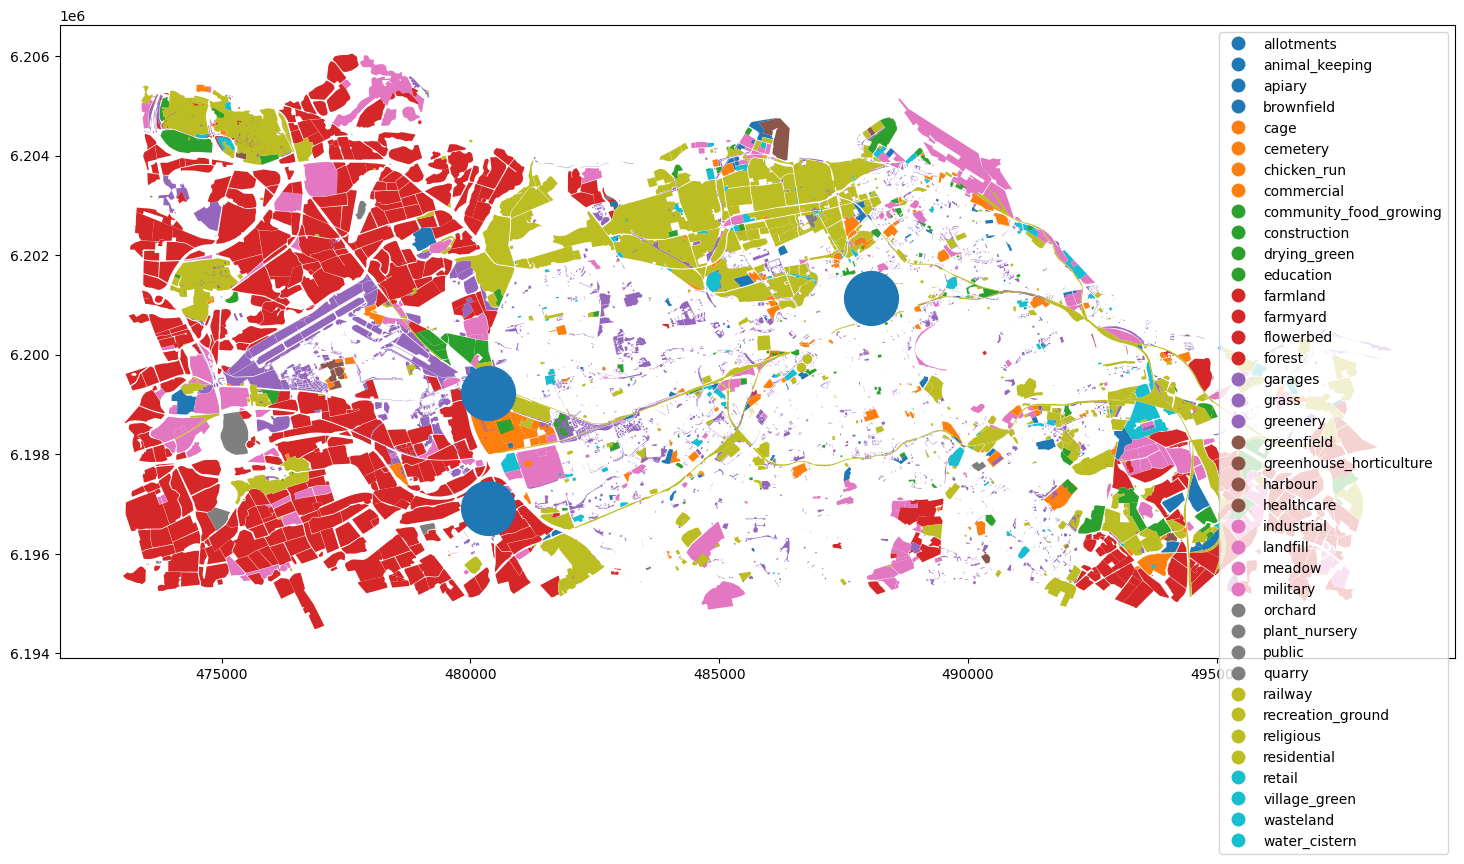

In [56]:
ax = land_use.plot(legend=True, column='landuse', figsize=(18,18))
bus_stations.plot(ax=ax, marker='o', markersize=1500)

### Plot City map

/var/folders/tc/bhmfz13j27n60j21fz769zw00000gn/T/ipykernel_72381/1920129138.py:7: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subway_stations.plot(ax=ax, c='gold', markersize = 30)


<Axes: >

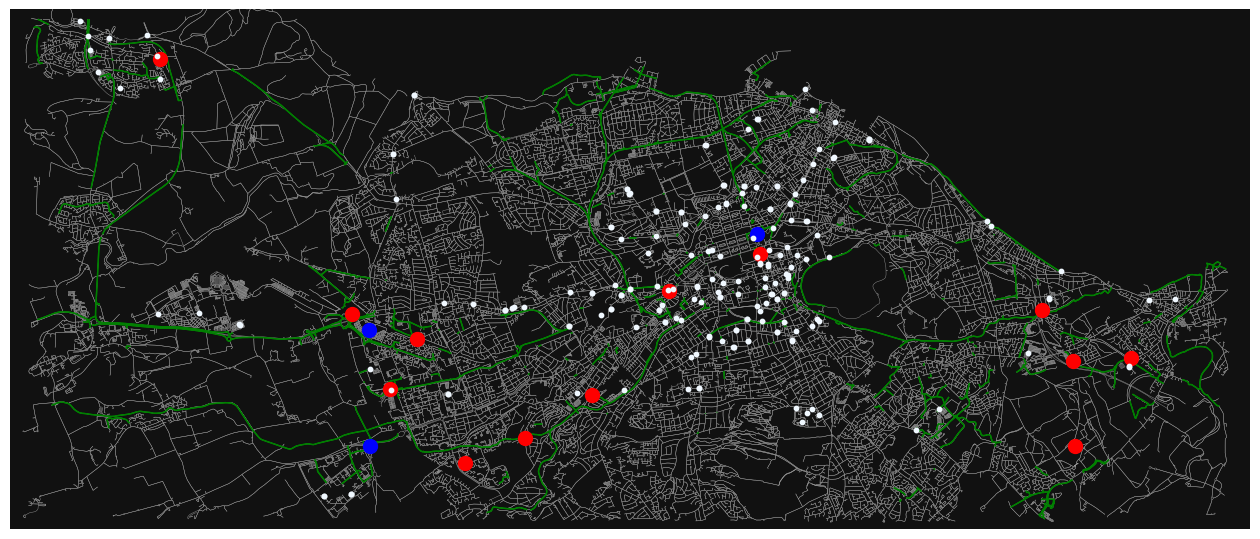

In [57]:
fig, ax = ox.plot_graph(G_bikes_projected, node_size=0, edge_linewidth=.3, figsize=(16,16), show=False)
ox.plot_graph(cycleway_graph, node_size=0, edge_color='green', ax=ax, show=False)

other_stations.plot(ax=ax, c='red', markersize = 100)
bus_stations.plot(ax=ax, c='blue', markersize = 100)

subway_stations.plot(ax=ax, c='gold', markersize = 30)

bike_sharing_stations.plot(ax=ax, c='aliceblue', markersize = 10)

#q = "landuse in ('residential', 'commercial', 'industrial', 'retail')"
#land_use.query(q).plot(column='landuse', alpha=.4, ax=ax, zorder=-1, legend=True)